In [8]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input,AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
"""Data Augmentation"""

train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Train',
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))

Found 11047 images belonging to 2 classes.


In [5]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= '../inception_resnetv2/Data/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 1377 images belonging to 2 classes.
Found 1384 images belonging to 2 classes.


In [6]:
basenet16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape = (224,224,3))
basenet16.trainable= False

In [19]:
basenet16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
x = Flatten()(basenet16.output)
d1 = Dense(1024, activation= 'relu')(x)
dr1 = Dropout(0.5)(d1)
d2 = Dense(1024, activation= 'relu')(dr1)
dr2 = Dropout(0.5)(d2)
prediction= Dense(units=1 , activation='sigmoid')(dr2)

model2= Model(basenet16.input,prediction)

In [25]:
model2.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [26]:
early = EarlyStopping(monitor='accuracy',patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',
                                            patience = 2,
                                            factor=0.3,
                                            min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [27]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9092637400622192, 1: 0.6773975962717684}


In [28]:
hist = model2.fit(train,
                  steps_per_epoch= len(train),
                  epochs= 50,
                  validation_data= valid,
                  class_weight=cw,
                  validation_steps= len(test),
                  callbacks=callbacks_list)

Epoch 1/50
173/173 [==============================] - 175s 843ms/step - loss: 0.6829 - accuracy: 0.7412 - val_loss: 0.3826 - val_accuracy: 0.8425
Epoch 2/50
173/173 [==============================] - 127s 730ms/step - loss: 0.4527 - accuracy: 0.7778 - val_loss: 0.2946 - val_accuracy: 0.8627
Epoch 3/50
173/173 [==============================] - 125s 721ms/step - loss: 0.4447 - accuracy: 0.7491 - val_loss: 0.2933 - val_accuracy: 0.8743
Epoch 4/50
173/173 [==============================] - 132s 762ms/step - loss: 0.4015 - accuracy: 0.7617 - val_loss: 0.2682 - val_accuracy: 0.9046
Epoch 5/50
173/173 [==============================] - 118s 682ms/step - loss: 0.3596 - accuracy: 0.8454 - val_loss: 0.2627 - val_accuracy: 0.9133
Epoch 6/50
173/173 [==============================] - 121s 697ms/step - loss: 0.3488 - accuracy: 0.8593 - val_loss: 0.2739 - val_accuracy: 0.9176
Epoch 7/50
173/173 [==============================] - 124s 714ms/step - loss: 0.3428 - accuracy: 0.8678 - val_loss: 0.2238 -

In [29]:
test_accu = model2.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

22/22 [==============================] - 40s 2s/step - loss: 0.1888 - accuracy: 0.9426
The testing accuracy is : 94.26289200782776 %


In [2]:
preds = model2.predict(test,verbose=1)

NameError: name 'model2' is not defined

In [30]:
preds = model2.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

22/22 [==============================] - 23s 1s/step


In [1]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual COVID"],
columns=["Predicted Normal", "Predicted COVID"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

NameError: name 'pd' is not defined

In [32]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.86      0.89       360
       COVID       0.95      0.97      0.96      1017

    accuracy                           0.94      1377
   macro avg       0.93      0.91      0.92      1377
weighted avg       0.94      0.94      0.94      1377



In [33]:
y_true=test.classes

In [34]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

**Overall Results**
Accuracy Result: 94.26%
Precision Result: 95.01%
Recall Result: 97.35%
F-Score Result: 96.16%


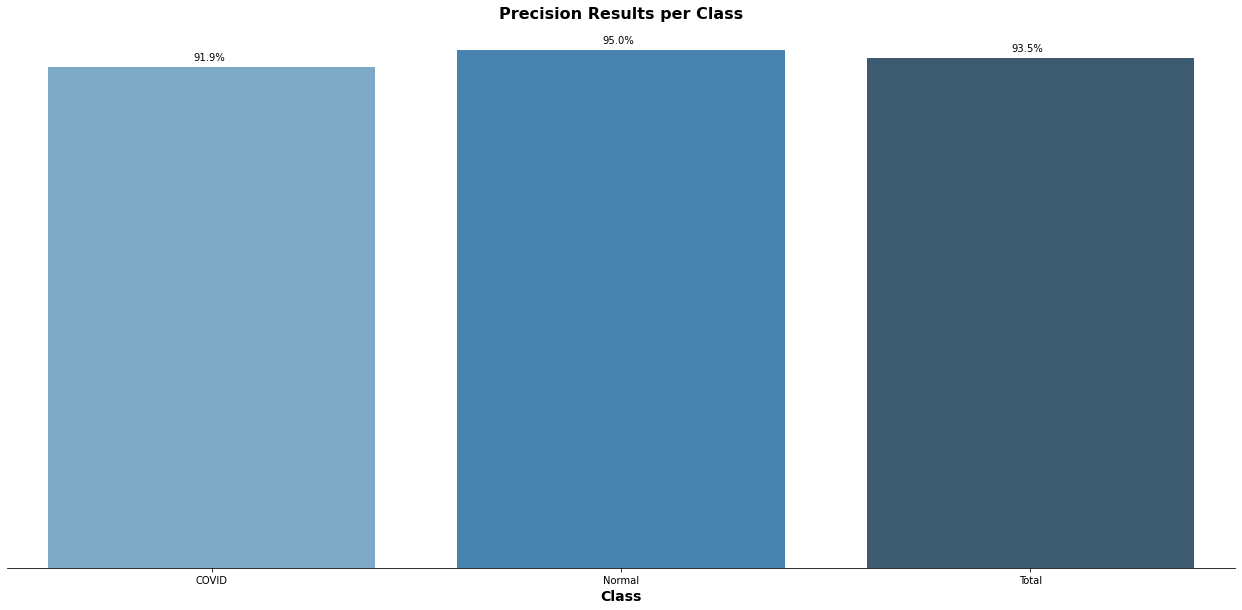

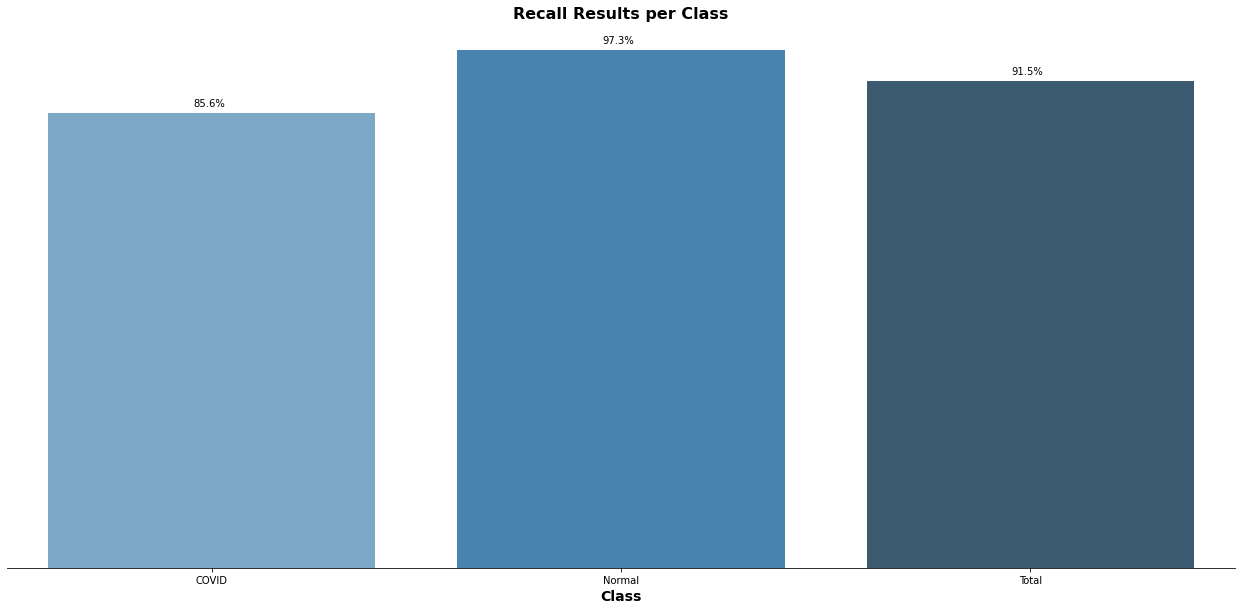

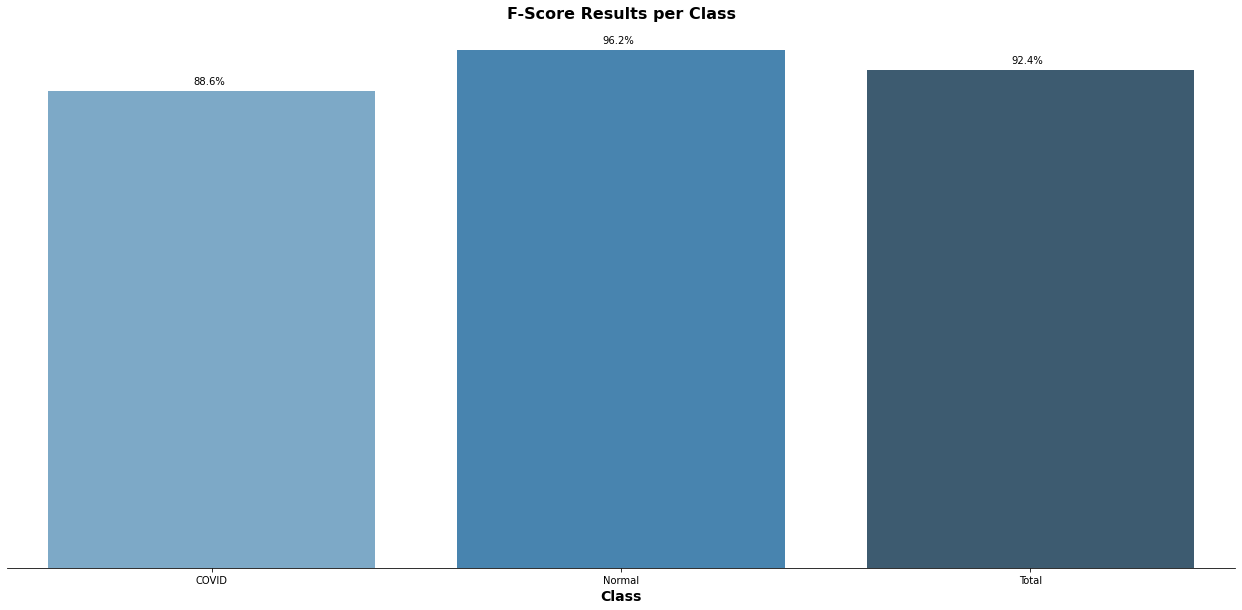

In [35]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

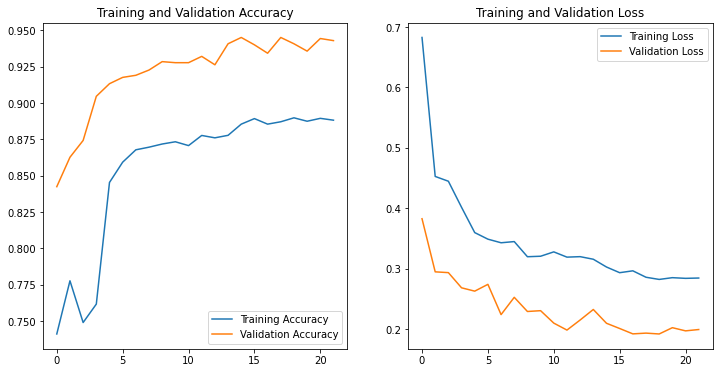

In [37]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()